In [340]:
!git clone https://github.com/MikolajMezyk/projektML.git
%cd projektML

Cloning into 'projektML'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 10), reused 16 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 679.91 KiB | 3.37 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/projektML/projektML/projektML/projektML/projektML/projektML


In [341]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import plotly.express as px

###Rozeznanie

In [342]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()




,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [343]:
print(data.shape)

(7043, 21)


In [344]:
print("\nOgólne rozeznanie:")
for column in data.columns:
    if (data[column].dtype == 'object'):
        print(f"Kolumna {column} ma {data[column].unique().shape[0]} różnych wartości")

print("\nCzy są puste wartości?")
display(data.isnull().sum())


Ogólne rozeznanie:
Kolumna customerID ma 7043 różnych wartości
Kolumna gender ma 2 różnych wartości
Kolumna Partner ma 2 różnych wartości
Kolumna Dependents ma 2 różnych wartości
Kolumna PhoneService ma 2 różnych wartości
Kolumna MultipleLines ma 3 różnych wartości
Kolumna InternetService ma 3 różnych wartości
Kolumna OnlineSecurity ma 3 różnych wartości
Kolumna OnlineBackup ma 3 różnych wartości
Kolumna DeviceProtection ma 3 różnych wartości
Kolumna TechSupport ma 3 różnych wartości
Kolumna StreamingTV ma 3 różnych wartości
Kolumna StreamingMovies ma 3 różnych wartości
Kolumna Contract ma 3 różnych wartości
Kolumna PaperlessBilling ma 2 różnych wartości
Kolumna PaymentMethod ma 4 różnych wartości
Kolumna TotalCharges ma 6531 różnych wartości
Kolumna Churn ma 2 różnych wartości

Czy są puste wartości?


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Preprocessing

Id Klienta nie daje na żadnej informacji

In [345]:
data = data.drop(columns=["customerID"])


Konwersja zmiennych numerycznych oraz obsługa brakujących wartości

In [346]:
numeric_cols = ["TotalCharges",  "MonthlyCharges", "tenure"]

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors="coerce")  # nieprawidłowe wartości -> NaN

print("Ilość Nan:")
print( data[numeric_cols].isna().sum())

for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())


Ilość Nan:
TotalCharges      11
MonthlyCharges     0
tenure             0
dtype: int64


Zmiana Churn z Yes/No na 1/0

In [347]:
data["Churn"] = (data["Churn"] == "Yes").astype(int)

Ujednolicenie wartości kategorii zmiennych na Yes i No

In [348]:
replace_map = {
    "No internet service": "No",
    "No phone service": "No"
}

for col in [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines"
]:
    data[col] = data[col].replace(replace_map)

Podział cech

In [349]:
numeric_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]

binary_features = [
    "SeniorCitizen"
]

categorical_features = [
    "gender", "Partner", "Dependents",
    "PhoneService", "MultipleLines",
    "InternetService",
    "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling",
    "PaymentMethod"
]


Preprocesor

In [350]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)


Podział klientów na typy - kubełki

In [351]:
data["tenure_bucket"] = pd.cut(
    data["tenure"],
    bins=[0, 6, 18, 100],
    labels=["0-6", "7-18", "19+"],
    right=True
)

Przygotowywanie danych do modeli

In [352]:
y = data["Churn"]
X = data.drop(columns=["Churn", "tenure_bucket"])

In [353]:
X_train, X_test, y_train, y_test, bucket_train, bucket_test = train_test_split(
    X, y, data["tenure_bucket"],
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Baseline

In [354]:
#najprostszy baseline
df_b = data.copy()
df_b["baseline_pred"] = (
    (df_b["tenure"] < 6) &
    (df_b["MonthlyCharges"] > 50)
).astype(int)

df = df_b.copy()

In [355]:
def print_classification_report_with_buckets(
    df: pd.DataFrame,
    y_true_col: str,
    y_pred_col: str,
    bucket_col: str = None,
    title: str = None
):
    if title:
        print("=" * len(title))
        print(title)
        print("=" * len(title))

    # -------- GLOBAL --------
    y_true = df[y_true_col]
    y_pred = df[y_pred_col]

    print("\nGLOBAL METRICS")
    print("--------------------")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # -------- BUCKETS --------
    if bucket_col:
        print(f"\nMETRICS PER BUCKET ({bucket_col})")
        print("--------------------")

        bucket_df = (
            df
            .groupby(bucket_col, observed=True)
            .apply(
                lambda x: pd.Series({
                    "recall": recall_score(
                        x[y_true_col],
                        x[y_pred_col],
                        zero_division=0
                    ),
                    "precision": precision_score(
                        x[y_true_col],
                        x[y_pred_col],
                        zero_division=0
                    ),
                    "churn_rate": x[y_true_col].mean(),
                    "n": len(x)
                }),
                include_groups=False
            )
            .reset_index()
        )

        print(bucket_df.to_string(index=False))


In [356]:
print_classification_report_with_buckets(
    df=df,
    y_true_col="Churn",
    y_pred_col="baseline_pred",
    bucket_col="tenure_bucket",
    title="BASELINE MODEL"
)

BASELINE MODEL

GLOBAL METRICS
--------------------
Accuracy : 0.7711
Precision: 0.6680
Recall   : 0.2734
F1-score : 0.3880

Confusion Matrix:
[[4920  254]
 [1358  511]]

METRICS PER BUCKET (tenure_bucket)
--------------------
tenure_bucket   recall  precision  churn_rate      n
          0-6 0.651786   0.672368    0.533333 1470.0
         7-18 0.000000   0.000000    0.343176 1253.0
          19+ 0.000000   0.000000    0.152007 4309.0


### Baseline z baseline fukncji straty LUV

Szacowanie ile klient z nami pozostanie

In [357]:
def expected_remaining_months(tenure):
    if tenure < 6:
        return 24
    elif tenure < 12:
        return 14
    elif tenure < 24:
        return 12
    elif tenure < 48:
        return 10
    else:
        return 6


In [358]:
df_b2 = data.copy()

df_b2["expected_remaining_months"] = df_b2["tenure"].apply(expected_remaining_months)
df_b2["remaining_LTV"] = df_b2["expected_remaining_months"] * df_b2["MonthlyCharges"]

df = df_b2


Baseline biznesowej funkcji błędu

In [359]:
def business_loss(y_true, y_pred, remaining_LTV, monthly_fee):
    cost_retention = 20 + 3 * monthly_fee #koszt obsługi potencjalnego churnu w $

    loss = 0

    if y_true == 1 and y_pred == 0:  # FN
        loss = remaining_LTV
    elif y_true == 1 and y_pred == 1:  # TP
        loss = cost_retention
    elif y_true == 0 and y_pred == 1:  # FP
        loss = cost_retention

    return loss

Baseline

In [360]:
# z modelu baseline
df["baseline_pred"] = (
    (df["tenure"] < 6) &
    (df["MonthlyCharges"] > 50)
).astype(int)


df["loss_baseline"] = df.apply(
    lambda row: business_loss(
        y_true=row["Churn"],
        y_pred=row["baseline_pred"],
        remaining_LTV=row["remaining_LTV"],
        monthly_fee=row["MonthlyCharges"]
    ),
    axis=1
)

total_loss_baseline = df["loss_baseline"].sum()

df["loss_no_action"] = df["Churn"] * df["remaining_LTV"]
total_loss_no_action = df["loss_no_action"].sum()


# wynik
print(f"Total loss – no action: ${total_loss_no_action:,.0f}")
print(f"Total loss – baseline: ${total_loss_baseline:,.0f}")
print(f"Loss reduction vs no action: ${(total_loss_no_action - total_loss_baseline):,.0f}")


Total loss – no action: $2,090,674
Total loss – baseline: $1,336,614
Loss reduction vs no action: $754,059


Confusion matrix

In [361]:
df.groupby(["Churn", "baseline_pred"]).size()


Churn  baseline_pred
0      0                4920
       1                 254
1      0                1358
       1                 511
dtype: int64

### Biznesowa funkcja straty

Łączna strata finansowa dla zadanego progu decyzyjnego

In [362]:
def total_business_loss_for_threshold(threshold, y_proba):
    df_test_reset = df_test.reset_index(drop=True)
    y_proba_reset = pd.Series(y_proba).reset_index(drop=True)

    y_pred_local = (y_proba_reset >= threshold).astype(int)

    loss = df_test_reset.apply(
        lambda row: business_loss(
            y_true=row["Churn"],
            y_pred=y_pred_local[row.name],
            remaining_LTV=row["remaining_LTV"],
            monthly_fee=row["MonthlyCharges"]
        ), axis=1
    )
    return loss.sum()

Strata finansowa w kubełkach klientów dla wspólnego progu

In [363]:
def bucket_losses_for_threshold(threshold, y_proba):
    df_test_reset = df_test.reset_index(drop=True)
    y_proba_reset = pd.Series(y_proba).reset_index(drop=True)

    y_pred_local = (y_proba_reset >= threshold).astype(int)

    df = df_test_reset.copy()
    df["loss"] = df.apply(
        lambda row: business_loss(
            y_true=row["Churn"],
            y_pred=y_pred_local[row.name],
            remaining_LTV=row["remaining_LTV"],
            monthly_fee=row["MonthlyCharges"]
        ),
        axis=1
    )

    return (
        df
        .assign(
            tenure_bucket=df["tenure_bucket"]
            .astype("string")
            .fillna("UNKNOWN")
        )
        .groupby("tenure_bucket")["loss"]
        .sum()
        .reset_index()
    )


Strata finansowa w pojedyńczym kubełku klientów dla danego progu

In [364]:
def loss_for_bucket(bucket_df, threshold, y_proba_local):
    #bucket_df_reset = bucket_df.reset_index(drop=True)
    y_pred_local = (y_proba_local >= threshold).astype(int)

    loss = bucket_df.apply(
        lambda row: business_loss(
            y_true=row["Churn"],
            y_pred=y_pred_local[row.name],
            remaining_LTV=row["remaining_LTV"],
            monthly_fee=row["MonthlyCharges"]
        ), axis=1
    )
    return loss.sum()

Wyznaczanie optymalnych progów dla poszczególnych kubełków klientów

In [365]:
def find_optimal_buckets_thresholds(y_proba, df_test):
  buckets = df_test["tenure_bucket"].dropna().unique()
  y_proba_s = pd.Series(y_proba, index=df_test.index)
  thresholds = np.linspace(0, 1, 101)

  results = []
  total_loss_global = 0.0

  for b in buckets:
      bucket_df = df_test[df_test["tenure_bucket"] == b]
      y_proba_local = y_proba_s.loc[bucket_df.index]

      losses = [loss_for_bucket(bucket_df, t, y_proba_local) for t in thresholds]

      best_idx = np.argmin(losses)
      best_threshold = thresholds[best_idx]
      best_loss = losses[best_idx]

      results.append({
          "bucket": b,
          "best_threshold": best_threshold,
          "expected_loss": best_loss
      })

      total_loss_global += best_loss

  results_df = pd.DataFrame(results)


  return results_df, total_loss_global

### Regresja Logistyczna

In [366]:
df_lr = data.copy()
df_lr["expected_remaining_months"] = df_lr["tenure"].apply(expected_remaining_months)
df_lr["remaining_LTV"] = df_lr["expected_remaining_months"] * df_lr["MonthlyCharges"]

df = df_lr

features = ["tenure", "MonthlyCharges"]  # baseline + możesz dorzucić inne
X = df[features]
y = df["Churn"]

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [367]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

y_proba_lr = clf.predict_proba(X_test_scaled)[:,1]

In [368]:
thresholds = np.linspace(0, 1, 101)
losses = [total_business_loss_for_threshold(t, y_proba_lr) for t in thresholds]

best_idx = np.argmin(losses)
best_threshold = thresholds[best_idx]

print(f"Best threshold (minimal loss): {best_threshold:.2f}")
print(f"Expected loss at this threshold: ${losses[best_idx]:,.0f}")


Best threshold (minimal loss): 0.21
Expected loss at this threshold: $194,743


In [369]:
bucket_losses_df = bucket_losses_for_threshold(best_threshold, y_proba_lr)
print(bucket_losses_df)

total_loss = bucket_losses_df["loss"].sum()
print(f"\nTotal expected loss (all buckets): ${total_loss:,.0f}")


  tenure_bucket      loss
0           0-6  57223.10
1           19+  92907.75
2          7-18  44189.75
3       UNKNOWN    422.40

Total expected loss (all buckets): $194,743


In [370]:
result = find_optimal_buckets_thresholds(y_proba_lr, df_test)
print(result[0])
print(f"\nTotal expected loss (all buckets): ${result[1]:,.0f}")

  bucket  best_threshold  expected_loss
0    19+            0.40       84884.10
1   7-18            0.41       42227.55
2    0-6            0.20       56252.00

Total expected loss (all buckets): $183,364


### RandomForestClassifier

In [371]:
df_rf = data.copy()
df_rf["expected_remaining_months"] = df_rf["tenure"].apply(expected_remaining_months)
df_rf["remaining_LTV"] = df_rf["expected_remaining_months"] * df_rf["MonthlyCharges"]
# z modelu baseline
df_rf["baseline_pred"] = (
    (df_rf["tenure"] < 6) &
    (df_rf["MonthlyCharges"] > 50)
).astype(int)

df = df_rf

X = df.drop(columns=["Churn", "baseline_pred", "remaining_LTV", "expected_remaining_months"])
X = pd.get_dummies(X, drop_first=True)
y = df["Churn"]

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:,1]

thresholds = np.linspace(0, 1, 101)
losses = [total_business_loss_for_threshold(t, y_proba_rf) for t in thresholds]

best_idx = np.argmin(losses)
best_threshold = thresholds[best_idx]

print(f"Best threshold RF (minimal loss): {best_threshold:.2f}")
print(f"Expected loss RF at this threshold: ${losses[best_idx]:,.0f}")

Best threshold RF (minimal loss): 0.30
Expected loss RF at this threshold: $183,762


In [372]:
bucket_losses_df = bucket_losses_for_threshold(best_threshold, y_proba_rf)
print(bucket_losses_df)

total_loss = bucket_losses_df["loss"].sum()
print(f"\nTotal expected loss (all buckets): ${total_loss:,.0f}")

  tenure_bucket      loss
0           0-6  61573.70
1           19+  81994.45
2          7-18  40193.85
3       UNKNOWN      0.00

Total expected loss (all buckets): $183,762


In [373]:
result = find_optimal_buckets_thresholds(y_proba_rf, df_test)
print(result[0])
print(f"\nTotal expected loss (all buckets): ${result[1]:,.0f}")

  bucket  best_threshold  expected_loss
0    19+            0.41       77516.85
1   7-18            0.27       39583.10
2    0-6            0.11       56678.90

Total expected loss (all buckets): $173,779


### GradientBoostingClassifier

In [374]:
df_gb = data.copy()
df_gb["expected_remaining_months"] = df_gb["tenure"].apply(expected_remaining_months)
df_gb["remaining_LTV"] = df_gb["expected_remaining_months"] * df_gb["MonthlyCharges"]
# z modelu baseline
df_gb["baseline_pred"] = (
    (df_rf["tenure"] < 6) &
    (df_rf["MonthlyCharges"] > 50)
).astype(int)

df = df_gb

X = df.drop(columns=["Churn", "baseline_pred", "expected_remaining_months", "remaining_LTV"])
y = df["Churn"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=np.number).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)
gb_clf.fit(X_train_scaled, y_train)

y_proba_gb = gb_clf.predict_proba(X_test_scaled)[:,1]


thresholds = np.linspace(0, 1, 101)
losses = [total_business_loss_for_threshold(t, y_proba_gb) for t in thresholds]

best_idx = np.argmin(losses)
best_threshold = thresholds[best_idx]

print(f"Best threshold GBM (minimal loss): {best_threshold:.2f}")
print(f"Expected loss GBM at this threshold: ${losses[best_idx]:,.0f}")


Best threshold GBM (minimal loss): 0.27
Expected loss GBM at this threshold: $191,130


In [375]:
bucket_losses_df = bucket_losses_for_threshold(best_threshold, y_proba_gb)
print(bucket_losses_df)

total_loss = bucket_losses_df["loss"].sum()
print(f"\nTotal expected loss (all buckets): ${total_loss:,.0f}")

  tenure_bucket     loss
0           0-6  62952.2
1           19+  87427.4
2          7-18  40750.1
3       UNKNOWN      0.0

Total expected loss (all buckets): $191,130


In [376]:
result = find_optimal_buckets_thresholds(y_proba_gb, df_test)
print(result[0])
print(f"\nTotal expected loss (all buckets): ${result[1]:,.0f}")

  bucket  best_threshold  expected_loss
0    19+            0.46       77348.35
1   7-18            0.30       40717.60
2    0-6            0.08       56529.45

Total expected loss (all buckets): $174,595


### Analiza

#### Analiza sensu wyliczonego ppb

In [377]:
print(len(y_proba_rf))
print(len(y_proba_lr))
print(len(y_proba_gb))
print(len(df_test["Churn"].astype(int).values))

1409
1409
1409
1409


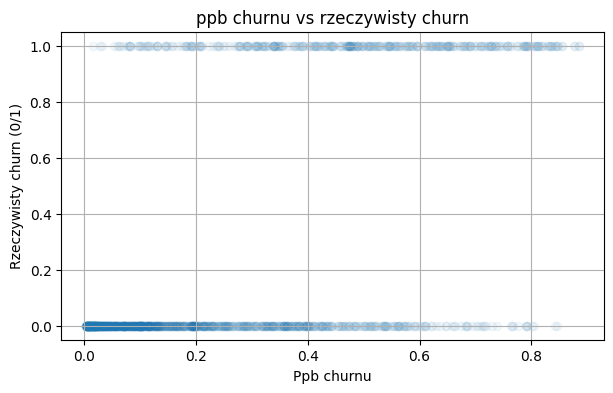

In [378]:
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df_rf, test_size=0.2, random_state=42, stratify=y
)

p_test = y_proba_rf
y_true = df_test["Churn"].astype(int).values

plt.figure(figsize=(7,4))
plt.scatter(p_test, y_true, alpha=0.05)

plt.xlabel("Ppb churnu")
plt.ylabel("Rzeczywisty churn (0/1)")
plt.title("ppb churnu vs rzeczywisty churn")

plt.grid(True)
plt.show()



Bierzemy ppb churnu z modelu i dzielimy go na 20 kubełków  
Dla każdego kubełka bierzemy rekordy z niego (rekordy z ppb churnu z modelu miezczącym się w zakresie kubełka dla nich) i liczymy ilość $$naprawdę_{odeszła}$$ czyli w df["Churn"] = 1
i robimy dla każdego kubełkaśrednią = $$\frac{suma(naprawdę_{odeszła})}{suma(wszyscy)}$$

Oy = ppb churnu z modelu
Ox = średnia dla każdego kubełka

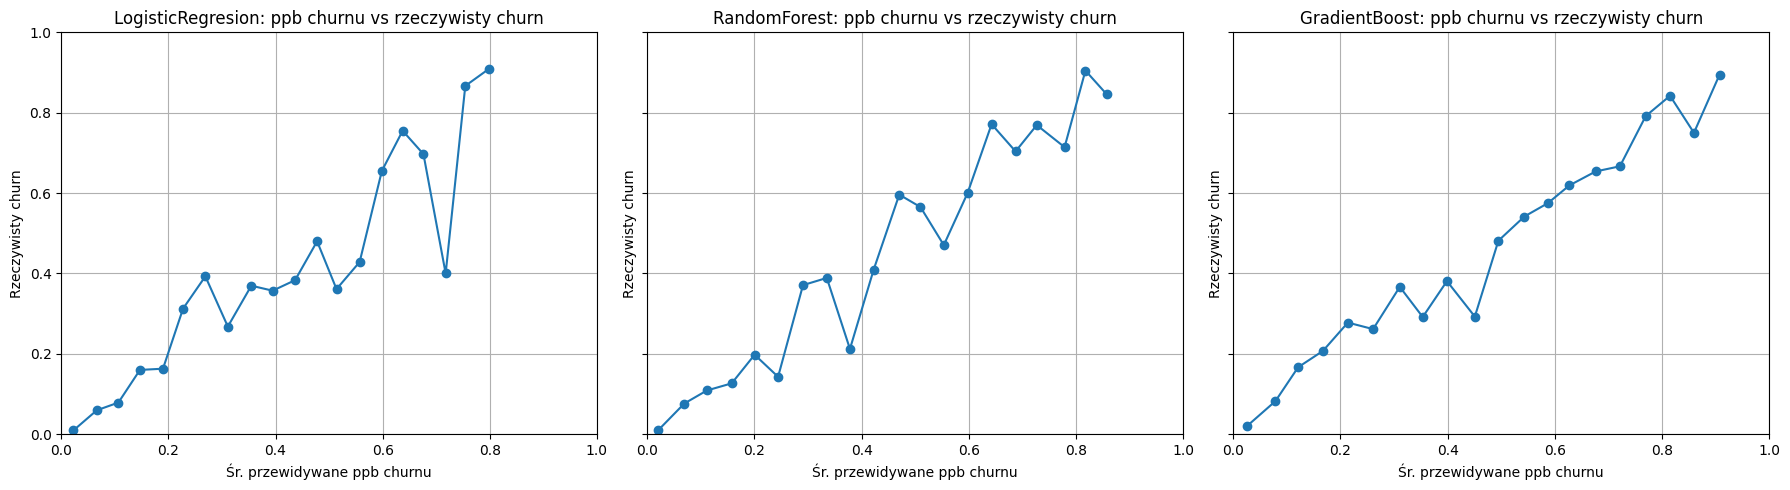

In [390]:
def plot_calibration_like(ax, df_model, y_proba, title, bins=20):

    X = df_model.drop(columns=["Churn"], errors="ignore")
    y = df_model["Churn"]

    X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
        X, y, df_model, test_size=0.2, random_state=42, stratify=y
    )

    y_true = df_test["Churn"].astype(int).values
    p_test = np.asarray(y_proba)


    df_tmp = pd.DataFrame({"p_churn": p_test, "y_true": y_true})
    df_tmp["bin"] = pd.cut(df_tmp["p_churn"], bins=bins, include_lowest=True)

    stats = df_tmp.groupby("bin", observed=True).mean()

    ax.plot(stats["p_churn"], stats["y_true"], marker="o", linewidth=1.5)
    ax.set_xlabel("Śr. przewidywane ppb churnu")
    ax.set_ylabel("Rzeczywisty churn")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

plot_calibration_like(axes[0], df_lr, y_proba_lr,  "LogisticRegresion: ppb churnu vs rzeczywisty churn", bins=20)
plot_calibration_like(axes[1], df_rf, y_proba_rf, "RandomForest: ppb churnu vs rzeczywisty churn", bins=20)
plot_calibration_like(axes[2], df_gb, y_proba_gb, "GradientBoost: ppb churnu vs rzeczywisty churn", bins=20)

plt.tight_layout()
plt.show()


#### Symulacja

Koszt akcji = months_free * monthly_charge + agent_cost

Wartość = remaining_months * monthly_charges

Model daje ppb churnu p_i  

Reagujemy jeśli: p_i * wartość_i > koszt akcji_i

In [382]:
def tendure_bucket(tenure):
    if tenure <= 3:
        return "0-3"
    elif tenure <= 6:
        return "4-6"
    elif tenure <= 12:
        return "7-12"
    elif tenure <= 24:
        return "13-24"
    else:
        return "25+"


remaining_months = {
    "0-3": 24,
    "4-6": 14,
    "7-12": 12,
    "13-24": 10,
    "25+": 6
}


In [383]:
def simulate(df, p_churn, months_free, agent_cost):

    monthly = df["MonthlyCharges"].values
    y = df["Churn"].values.astype(int)

    exp_months = df["tenure"].apply(lambda x: remaining_months[tendure_bucket(x)]).values
    value = exp_months * monthly

    cost = months_free * monthly + agent_cost
    action = (p_churn * value > cost).astype(int)
    profit = (y * action * value - action * cost).sum()

    coverage = action.mean()
    recall = action[y == 1].mean() if y.sum() > 0 else 0.0

    return profit, coverage, recall




In [384]:
p_test = y_proba_gb
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
        X, y, df_gb, test_size=0.2, random_state=42, stratify=y
    )
df = df_gb

months_free = [1, 2, 3, 4, 5]
agent_cost = [50, 100, 200, 300, 400]
rows = []

for m in months_free:
  for c in agent_cost:
    profit, coverage, recall = simulate(df_test, p_test, m, c)
    rows.append({
            "months_free": m,
            "agent_cost": c,
            "profit": profit,
            "coverage_%": 100 * coverage,
            "recall": recall
        })

In [385]:
results = pd.DataFrame(rows).sort_values(["months_free", "agent_cost"])
results

,months_free,agent_cost,profit,coverage_%,recall
0,1,50,259960.10,45.564230,0.836898
1,1,100,227775.45,38.892832,0.762032
2,1,200,186983.75,27.537260,0.625668
3,1,300,147111.70,21.717530,0.510695
4,1,400,120831.90,18.594748,0.459893
5,2,50,218915.50,36.195884,0.737968
6,2,100,195902.80,30.872960,0.660428
7,2,200,158802.30,23.207949,0.548128
8,2,300,127117.20,19.517388,0.475936
9,2,400,104622.30,15.897800,0.409091


In [386]:
fig = px.scatter_3d(
    results,
    x="months_free",
    y="agent_cost",
    z="profit",
    color="profit",
    size="coverage_%",
    color_continuous_scale="Viridis",
    title="Business Profit Simulation",
    labels={
        "months_free": "Months Free",
        "agent_cost": "Agent Cost ($)",
        "profit": "Total profit ($)",
        "coverage_%": "Coverage (%)"
    }
)

fig.show()


In [389]:
def prepare_df_pred(df, y_proba):
    n = min(len(df), len(y_proba))
    df_used = df.reset_index(drop=True).iloc[:n]
    y_used = pd.Series(y_proba).reset_index(drop=True).iloc[:n]
    return df_used, y_used


min_len = min(len(df_test), len(y_proba_lr), len(y_proba_rf), len(y_proba_gb))
df_test_trim = df_test.reset_index(drop=True).iloc[:min_len]

y_lr_trim = pd.Series(y_proba_lr).reset_index(drop=True).iloc[:min_len]
y_rf_trim = pd.Series(y_proba_rf).reset_index(drop=True).iloc[:min_len]
y_gb_trim = pd.Series(y_proba_gb).reset_index(drop=True).iloc[:min_len]

models = {
    "LogReg": y_lr_trim,
    "RandomForest": y_rf_trim,
    "GradientBoosting": y_gb_trim
}

months_free = [1, 2, 3, 4, 5]
agent_cost = [50, 100, 200, 300, 400]

all_rows = []

for model_name, y_model in models.items():
    df_model = df_test_trim.copy()
    for m in months_free:
        for c in agent_cost:
            profit, coverage, recall = simulate(df_model, y_model, m, c)
            all_rows.append({
                "model": model_name,
                "months_free": m,
                "agent_cost": c,
                "profit": profit,
                "coverage_%": 100 * coverage,
                "recall": recall
            })


results = pd.DataFrame(all_rows).sort_values(["model", "months_free", "agent_cost"])
results


fig = px.scatter_3d(
    results,
    x="months_free",
    y="agent_cost",
    z="profit",
    color="model",
    size="coverage_%",
    symbol="model",
    title="Business Profit Simulation Across Models",
    labels={
        "months_free": "Months Free",
        "agent_cost": "Agent Cost ($)",
        "profit": "Total Profit ($)",
        "coverage_%": "Coverage (%)",
        "model": "Model"
    },
    color_discrete_map={"LogReg": "blue", "RandomForest": "green", "GradientBoosting": "red"}
)

fig.show()
